### Bonus Question

The circuit used as a case study in this question is also similar to the one in the main questions, specifically in the case of 3 qubits. The circuit is drawn below:

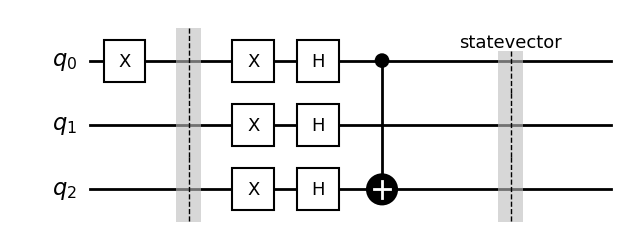

### 1. Sample final states in the statevector or tensor representations


Sampling final will apply quantum measurement to the state of a qubit. This measurement typically projects the state onto the computational basis states, which are \( |0\rangle \) and \( |1\rangle \). The corresponding projectors for these states are:

\begin{align*}
    \text{Projector for } |0\rangle: & \quad P_0 = |0\rangle \langle 0| = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \\
    \text{Projector for } |1\rangle: & \quad P_1 = |1\rangle \langle 1| = \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}

When we measure a qubit, we apply one of these projectors. The measurement outcome (either $ |0\rangle $ or $ |1\rangle $) depends on the probabilities derived from the state's amplitudes. After applying a projector, we normalize the resulting state to reflect the new state of the qubit after measurement.

In [156]:
import time
import numpy as np
from scipy.linalg import norm

# Define projectors for |0⟩ and |1⟩
projectors = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])]

To determine the outcome of a measurement, first calculate the probabilities of obtaining each state. For example, for a qubit in the state 

$$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle,$$

the probabilities of measuring $|0\rangle$ and $|1\rangle$ are calculated using the projectors $P_0$ and $P_1$:

$$P(0) = \langle \psi | P_0 | \psi \rangle = |\alpha|^2,$$

$$P(1) = \langle \psi | P_1 | \psi \rangle = |\beta|^2.$$


Once the probabilities are determined, we can measure the qubit and obtain further results. 

#### 1.a Custom Simulator Sampler 

In [157]:
H_gate = 1/np.sqrt(2)*np.array([[1,1],
                    [1,-1]])

X_gate = np.array([[0,1],
                   [1,0]])

CNOT_gate = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,0,1],
                    [0,0,1,0]]).reshape(2,2,2,2)

def apply_single_qubit_gate(state, gate, target_qubit):

    psi_updated = np.tensordot(gate, state, axes=(1,target_qubit))
    psi_updated = np.moveaxis(psi_updated, 0, target_qubit)

    return psi_updated

def apply_cnot_gate(state, target_qubit, control_qubit):

    psi_updated = np.tensordot(CNOT_gate, state, ((2,3), (control_qubit, target_qubit)))
    psi_updated = np.moveaxis(state, (0,1), (control_qubit, target_qubit))

    return psi_updated

def quantum_simulator(N):
    
    start_time = time.time()

    psi = np.zeros((2,)*N)
    psi[(0,)*N] = 1 #initiate example state: |000...001> 
    
    for i in range(N): # apply the gate for each qubit
        psi = apply_single_qubit_gate(psi, X_gate, i)
        psi = apply_single_qubit_gate(psi, H_gate, i)
    
    psi = apply_cnot_gate(psi, N-1, 0)
    
    end_time = time.time()
    runtime = end_time - start_time

    result = psi
    
    return result, runtime


In [158]:
N_qubit = 3
result, runtime = quantum_simulator(N_qubit)
result

array([[[ 0.35355339, -0.35355339],
        [-0.35355339,  0.35355339]],

       [[-0.35355339,  0.35355339],
        [ 0.35355339, -0.35355339]]])

In [239]:
# Project state onto |0⟩ or |1⟩ for qubit i
def project(i, j, state):
    projected = np.tensordot(projectors[j], state, (1, i))
    return np.moveaxis(projected, 0, i)


# Measure qubit
def measure(i, psi):
    # Project onto |0⟩ for qubit i and calculate the probability of measuring |0⟩
    projected_0 = project(i, 0, psi)
    prob_0 = norm(projected_0.flatten())**2  

    if np.random.random() < prob_0:
        psi = projected_0 / norm(projected_0)  
        return 0, psi
    else:
        projected_1 = project(i, 1, psi)
        psi = projected_1 / norm(projected_1)  
        return 1, psi

# Measure the first qubit
outcome, state = measure(0, result)
print("Measurement result of qubit-0:", outcome)
print("State after measurement:", state.flatten())

Measurement result of qubit-0: 1
State after measurement: [ 0.   0.   0.   0.  -0.5  0.5  0.5 -0.5]


In [252]:
count_0 = 0 # count of measurement outcome 0
count_1 = 0 # count of measurement outcome 1
N_qubit = 3 # Number of qubits
shots = 100

print("Measurement Results:")
for i in range(shots):
    state, runtime = quantum_simulator(N_qubit)
    outcome, state = measure(0, state)
    print(outcome, end='')

    if outcome == 0:
        count_0 += 1
    else:
        count_1 += 1

prob_0 = count_0/shots
prob_1 = count_1/shots

print("\n\nProbability of |0>:", prob_0)
print("\nProbability of |1>:", prob_1)

Measurement Results:
0100001111100010110100000111000110001011111101000110110001000010100110100011001110101101101111100111

Probability of |0>: 0.49

Probability of |1>: 0.51


#### 1.b Qiskit Simulator Sampler Results

In [333]:
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import SparsePauliOp

def qiskitSampler(verbose=False):
    qr = QuantumRegister(3, name='q')
    cr = ClassicalRegister(1, name='reg_classic')

    qc = QuantumCircuit(qr,cr)
    qc.x([0,1,2])
    qc.h([0,1,2])
    qc.cx(0,2)
    qc.measure(0, cr)

    sampler = SamplerV2(backend=AerSimulator())

    job = sampler.run([(qc, None, 100)])
    pub_result = job.result()[0]
    state = int(list(pub_result.data.reg_classic.get_counts(0).keys())[0])
    if verbose:
        print(f"State of the first qubit in circuit: {state} \n")
    return state

qiskitSampler(True)
print('')

State of the first qubit in circuit: 1 




In [345]:
count_0 = 0
count_1 = 0

for i in range(shots):
    outcome = qiskitSampler()
    print(outcome, end='')

    if outcome == 0:
        count_0 += 1
    else:
        count_1 += 1


prob_0 = count_0/shots
prob_1 = count_1/shots

print("\n\nProbability of |0> in the first qubit:", prob_0)
print("\nProbability of |1> in the first qubit:", prob_1)

1111010000000010100001110000010101101110100101101000101110101100011110101010110010001111011011010100

Probability of |0> in the first qubit: 0.51

Probability of |1> in the first qubit: 0.49


### 2. Calculating the Exact Expectation Value

The exact expectation value of an observable $\hat{O}$ in a given quantum state $|\Psi\rangle$ is calculated using the formula:

$$
\langle \hat{O} \rangle = \langle \Psi | \hat{O} | \Psi \rangle
$$


#### 2.a Custom Simulator Exact Estimator Results

Obtain the previous final state:

In [64]:
def n_kron_product(matrix, n):
    """
    calculate kron product of matrix n times. For example, used to expand the single-qubit quantum gate (H, X, ...) to all other qubits
    """

    result = matrix
    for i in range(n-1):
        result = np.kron(result, matrix)

    return result

def n_cnot_gate(n):
    """
    construct 2-qubit CNOT gate matrix representation. This code below allowed to customize the control and target qubit to create the corresponding circuits. In general, in this circuit example we will always use the control qubit in the first qubit (0) and the target qubit in the last (n-1)
    """

    dist = n - 2 # distance or the number of qubits between control and target qubit (in this case, always first and last qubit)

    sq_X = np.array([[0,1], [1,0]]) # single qubit X gate

    N = 2 ** (dist+2)
    N_half = int(N/2)

    I_half_N = np.identity(N_half)

    Zero_half_N = np.zeros((N_half, N_half))

    I_quarter_N = np.identity(int(N/4))
    right_bottom_matrix = np.kron(I_quarter_N, sq_X)
    
    # print("I_half_N", I_half_N)
    # print("Zero_half_N", Zero_half_N)
    # print("RB", right_bottom_matrix)

    CX = np.block([[I_half_N, Zero_half_N],
                [Zero_half_N, right_bottom_matrix]])

    # print(CX)
    # print(np.kron(I, CX))  
    return CX 

In [65]:
# qubits = 15
import time

# Define Single qubit state and gate
sq_ket_0 = np.array([1,0])
sq_ket_1 = np.array([0,1])

sq_I = np.array([[1,0], [0,1]])
sq_X = np.array([[0,1], [1,0]])
sq_H = 1/np.sqrt(2)*np.array([[1,1], [1,-1]])

dq_CNOT = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,0,1],
                    [0,0,1,0],])



def quantum_simulator(qubits):

    start_time = time.time()
    # Define n qubits quantum gates
    n_sq_X = n_kron_product(sq_X, qubits)
    n_sq_H = n_kron_product(sq_H, qubits)
    n_cnot = n_cnot_gate(qubits)

    # Define n qubits statevectors
    n_statevector = n_kron_product(sq_ket_0, qubits)
    # print(n_statevector)

    result = n_cnot @ n_sq_H @ n_sq_X @ n_statevector
    end_time = time.time()
    runtime = end_time - start_time
    # print(result)

    return result, runtime

In [91]:
N_qubits = 3
final_state = quantum_simulator(N_qubits)[0]
print("Final State:", final_state)

Final State: [ 0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339 -0.35355339
 -0.35355339  0.35355339]


In this example, we will try to measure the expectation value of Pauli Z oeprator:

In [92]:
single_qubit_pauli_z = np.array([[1, 0], [0, -1]])

pauli_z = np.kron(np.kron(single_qubit_pauli_z, single_qubit_pauli_z), single_qubit_pauli_z)
print(pauli_z)

[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]


Define the expectation value measurement function:
$$
\langle \hat{Z} \rangle = \langle \psi_{final state} | \hat{Z} | \psi_{final state} \rangle
$$


In [123]:
expectation_value = np.conjugate(final_state) @ pauli_z @ final_state
print(expectation_value)

0.0


The result is 0, as expected. It also matches the result from the Qiskit exact estimator (StateVector Estimator) shown below.

#### 2.b Custom Simulator Exact Estimator Results

In [149]:
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp('ZZZ')

qc = QuantumCircuit(3)
qc.x([0,1,2])
qc.h([0,1,2])
qc.cx(0,2)

estimator = StatevectorEstimator()

job = estimator.run([(qc, obs)])
exp_vals_aer = job.result()[0].data.evs
print(exp_vals_aer)

0.0
